In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
from shuttle_helpers import load
c = 0 #index of the conditional variable variable
train, test = load(c=c)
# too big to easily process on 1 GPU.
# Let us split it in 3 datasets
seed = 2
assert (seed>=0) & (seed<=2)
train = train[seed::3]
test  =  test[seed::3]
print(train.shape, test.shape)

(14500, 10) (4833, 10)


In [3]:
import sys
sys.path.insert(0, '/home/nina/CopulaGP/')
from marginal import heuristic_element_order
numbers = np.concatenate([train,test])
order = heuristic_element_order(numbers) 
# order is different for train vs. test, but we follow the vine.R by Hernandez-Lobato
order

array([7, 4, 9, 8, 0, 6, 2, 5, 1, 3])

In [4]:
import marginal as mg
X = train[:,c]
Xt = test[:,c]
Y_raw = train[:,order[order!=c]]
Yt_raw = test[:,order[order!=c]]
# conditional
Y = np.zeros_like(Y_raw)
Yt = np.zeros_like(Yt_raw)
for i, (y,yt) in enumerate(zip(Y_raw.T,Yt_raw.T)):
    # conditional
    Y[:,i] = mg.fast_signal2uniform(y,X)
    Yt[:,i] = mg.fast_signal2uniform(y,X,Y_=yt,X_=Xt)
    # unconditional
#     Y[:,i] = (np.argsort(Y_raw[:,i].flatten()).argsort()/Y_raw[:,i].size)\
#                 .reshape(Y_raw[:,i].shape)
#     Yt[:,i] = (np.argsort(Yt_raw[:,i].flatten()).argsort()/Yt_raw[:,i].size)\
#                  .reshape(Yt_raw[:,i].shape)
    print(i)


/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/fastkde/fastKDE.py:775: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dxProd = dxProd[cslice[::-1]]


0
1
2
3
4
5
6
7
8


(14500,)

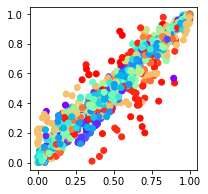

In [5]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 4
plt.scatter(*Yt[::skip,[4,5]].T,color=cm.rainbow(Xt[::skip]))
X.shape

In [6]:
import MI
Hs = []
for i in range(1,9):
    _,H = MI.BI_KSG(numbers[:,0].reshape(-1,1),numbers[:,i].reshape(-1,1))
    print(H)
    Hs.append(H)

-7.5518445999817825
-4.234754221640771
-7.419352991596385
-7.218445737563512
-2.6249188012645988
-4.0966844974104335
-2.32071398639638
-6.976711198937567


In [7]:
X.max()

0.9999827586206896

In [10]:
def normalize_Y(Y_all,min,max):
    return (Y_all - min)/(max-min)*0.998+0.001
d = {}
d['X'] = X
d['Xt'] = Xt
min = np.concatenate([Y,Yt]).min(0)
max = np.concatenate([Y,Yt]).max(0)
d['Y'] = normalize_Y(Y,min,max)
d['Yt'] = normalize_Y(Yt,min,max)
d['X_label'] = 'latitude'
# d['Y_labels'] = [] #TODO 
d['comment'] = 'All variables were sorted together (emp. kendalls tau), \
                    thenlatitude moved to the first position'

# here only keys X and Y are standard. The rest will be ignored by training code
path2data = '/home/nina/CopulaGP/examples/shuttle'
with open(f"{path2data}/outputs/shuttle{seed}_layer0.pkl",'wb') as f:
    pkl.dump(d,f)

In [ ]:
##############################
#       Train                #
##############################

from train import train_vine

exp = f'shuttle{seed}'
g = ''
path_data = lambda layer: f"{path2data}/outputs/{exp}{g}_layer{layer}.pkl"
path_models = lambda layer: f"{path2data}/outputs/{exp}{g}_models_layer{layer}.pkl"
path_final = f"{path2data}/outputs/{exp}{g}_trained.pkl"

gpus = [0,1]
result = train_vine(exp, path_data, path_models, path_final, gauss=False,
    device_list=[f'cuda:{i}' for i in gpus])


Starting shuttle2 layer 0/8
Error:[Errno 17] File exists: '/home/nina/CopulaGP/examples/shuttle/outputs/logs'
Error:[Errno 17] File exists: '/home/nina/CopulaGP/examples/shuttle/outputs/logs/layer0'
Selecting 0-1 on cuda:0
Selecting 0-2 on cuda:1
Selection took 1 min
0-1 FrankGaussian -0.263802170753479
Selecting 0-3 on cuda:0


In [14]:
with open(path_final,"rb") as f:
    data = pkl.load(f)
# # plot results
# plot_res = '{}/res_{}.png'.format(path_output,name)
# # print(X.shape,Y.shape,name_x,name_y,plot_res)
# Plot_Fit(model,X,Y,name_x,name_y,plot_res,device=device)
data

In [45]:
NN = len(trained['waics'][0])+1
WAICs = np.zeros((NN,NN))
for layer, ws in enumerate(trained['waics']):
    WAICs[layer,(layer+1):] = [-a for a in ws]
plt.imshow(WAICs[:])

TypeError: 'NoneType' object is not subscriptable

In [8]:
device = "cuda:0"

with open(f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttle{seed}_layer0.pkl","rb") as f:
    d = pkl.load(f)

#real
train_x = torch.tensor(d['X'], device=device).float()
train_y = torch.tensor(d['Y'], device=device).float()
test_x = torch.tensor(d['Xt'], device=device).float()
test_y = torch.tensor(d['Yt'], device=device).float()

# N_points=test_x.shape[0]

In [14]:
from vine import CVine
vine_base = CVine.marginalize(trained['models'],test_x,device=device)

In [15]:
vine = vine_base.truncate(5)
copgpT = vine.log_prob(test_y).mean()
copgp = vine_base.log_prob(test_y).mean()
(copgp,copgpT)
# X.shape

(tensor(3.8260, device='cuda:0'), tensor(2.8692, device='cuda:0'))

In [153]:
vine = CVine(copula_layers,test_x,device=device).truncate(5)
logprobT = vine.log_prob(test_y).mean()
vine = CVine(copula_layers,test_x,device=device)
logprob = vine.log_prob(test_y).mean()
(logprob,logprobT)

(tensor(3.8267, device='cuda:0'), tensor(3.0499, device='cuda:0'))

In [154]:
d['copula_layers'] = copula_layers
d['vine'] = vine 
d['copgp_logprob'] = copgp.item()
d['copgp_logprob_trunc5'] = copgpT.item() #cut 5 last layers, the same way as Hernandez-Lobato did in ICML
d['logprob'] = logprob.item()
d['logprob_trunc5'] = logprobT.item()
with open(f"res_shuttle{seed}.pkl","wb") as f:
    pkl.dump(d,f)

In [118]:
def report(arr):
    return f"{arr.mean():.3f}$\pm${arr.std():.3f}"